### Classification of Patient’s Condition & Drug Recommendation

### Importing libraries

In [1]:
import pandas as pd
import itertools
import string
import numpy as np
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
import matplotlib.pyplot as plt
%matplotlib inline
## show all rows of pandas data fram
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)

In [2]:
df =pd.read_csv("drugsComTrain_raw.tsv",sep ='\t')

In [3]:
df.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [4]:
df.condition.value_counts()

Birth Control                                                          28788
Depression                                                              9069
Pain                                                                    6145
Anxiety                                                                 5904
Acne                                                                    5588
Bipolar Disorde                                                         4224
Insomnia                                                                3673
Weight Loss                                                             3609
Obesity                                                                 3568
ADHD                                                                    3383
Diabetes, Type 2                                                        2554
Emergency Contraception                                                 2463
High Blood Pressure                                                     2321

In [5]:
df_train = df[(df["condition"]=="Depression")| (df["condition"]=="Pain") | (df["condition"]=="Anxiety") |(df["condition"]=="Weight Loss") ]

In [6]:
df_train.shape

(24727, 7)

In [7]:
df_train.head()

,Unnamed: 0,drugName,condition,review,rating,date,usefulCount
11,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0,"March 9, 2017",54
31,96233,Sertraline,Depression,"""1 week on Zoloft for anxiety and mood swings....",8.0,"May 7, 2011",3
32,204999,Toradol,Pain,"""I am 30 years old. I had a multiple composite...",10.0,"February 11, 2013",16
37,93678,Morphine,Pain,"""I have been on morphine for at least 7 years....",8.0,"May 8, 2010",19
44,121333,Venlafaxine,Depression,"""my gp started me on Venlafaxine yesterday to ...",4.0,"April 27, 2016",3


In [8]:
df_train.columns

Index(['Unnamed: 0', 'drugName', 'condition', 'review', 'rating', 'date',
       'usefulCount'],
      dtype='object')

In [9]:
X=df_train.drop(['Unnamed: 0','drugName','rating', 'date','usefulCount'], axis=1)

### EDA

In [10]:
X.condition.value_counts()

Depression     9069
Pain           6145
Anxiety        5904
Weight Loss    3609
Name: condition, dtype: int64

In [11]:
X.head()

,condition,review
11,Depression,"""I have taken anti-depressants for years, with..."
31,Depression,"""1 week on Zoloft for anxiety and mood swings...."
32,Pain,"""I am 30 years old. I had a multiple composite..."
37,Pain,"""I have been on morphine for at least 7 years...."
44,Depression,"""my gp started me on Venlafaxine yesterday to ..."


### Data Preprocessing

In [12]:
X["review"][11]

'"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."'

In [13]:
X["review"][32]

'"I am 30 years old. I had a multiple composite spinal injuries 15 years ago. The aches and pains unbearable. I started taking anti-inflammatories about 2 years ago. I started getting injections every month of Toradol and &quot;Depo&quot; something. I am almost off all pain meds I mean I still have bad days but I can function again."'

In [14]:
for i, col in enumerate(X.columns):
    X.iloc[:, i] = X.iloc[:, i].str.replace('"', '')

In [15]:
# To set the width of the column is maximum
pd.set_option('max_colwidth', -1)

C:\Users\chaud\AppData\Local\Temp/ipykernel_14472/2969463590.py:2: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('max_colwidth', -1)


In [16]:
X.head()

,condition,review
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects."
31,Depression,1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one but that subsided as the week went on. I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.
32,Pain,I am 30 years old. I had a multiple composite spinal injuries 15 years ago. The aches and pains unbearable. I started taking anti-inflammatories about 2 years ago. I started getting injections every month of Toradol and &quot;Depo&quot; something. I am almost off all pain meds I mean I still have bad days but I can function again.
37,Pain,I have been on morphine for at least 7 years..It is the only medicine that seems to manage my pain. Without it I would be in bed 90% of the time. With it I can have a life.
44,Depression,"my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took another one last night and was so ill i couldn,t stand ,being sick sweating shaking thought i was going to pass out. Did get some sleep hopeing to feel better this morning,took another one and felt so spaced out dry mouth shaking ,sick, so booked in to see gp again to make sure i should be feeling like this, only to find out she had put me on the wrong dose should have been on 37.5mg was put on 150mg, now on right dose hope this will be better"


### What are stopwords ?
Stopwords are the most common words in any natural language. For the purpose of building NLP models, these stopwords might not add much value to the meaning of the document.

The most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.

In [17]:
from nltk.corpus import stopwords

stop = stopwords.words("english")

In [18]:
stop

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [19]:
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem import LancasterStemmer


porter = PorterStemmer()

lemmatizer = WordNetLemmatizer()

snow = SnowballStemmer("english")

lanc =LancasterStemmer()

In [20]:
print(porter.stem("sportingly"))
print(porter.stem("very"))
print(porter.stem("troubled"))

sportingli
veri
troubl


In [21]:
print(snow.stem("sportingly"))
print(snow.stem("very"))
print(snow.stem("troubled"))

sport
veri
troubl


In [22]:
print(lanc.stem("sportingly"))
print(lanc.stem("very"))
print(lanc.stem("troubled"))

sport
very
troubl


In [23]:
print(lemmatizer.lemmatize("sportingly"))
print(lemmatizer.lemmatize("very"))
print(lemmatizer.lemmatize("troubled"))

sportingly
very
troubled


In [24]:
from bs4 import BeautifulSoup ## used to remove html element
import re ##subtituting the value

In [25]:
def review_to_words(raw_review):
    # 1. Delete HTML 
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords 
    meaningful_words = [w for w in words if not w in stop] #list comprivation
    # 6. lemmitization
    lemmitize_words = [lemmatizer.lemmatize(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(lemmitize_words))

In [26]:
X['review_clean'] = X['review'].apply(review_to_words)

In [27]:
X.head()

,condition,review,review_clean
11,Depression,"I have taken anti-depressants for years, with some improvement but mostly moderate to severe side affects, which makes me go off them.\r\n\r\nI only take Cymbalta now mostly for pain.\r\n\r\nWhen I began Deplin, I noticed a major improvement overnight. More energy, better disposition, and no sinking to the low lows of major depression. I have been taking it for about 3 months now and feel like a normal person for the first time ever. Best thing, no side effects.",taken anti depressant year improvement mostly moderate severe side affect make go take cymbalta mostly pain began deplin noticed major improvement overnight energy better disposition sinking low low major depression taking month feel like normal person first time ever best thing side effect
31,Depression,1 week on Zoloft for anxiety and mood swings. I take 50mg in the mornings with my breakfast. Nausea on day one but that subsided as the week went on. I get the jitters about 2 hrs after taking it followed by yawning. I feel much better though and less angry/stressed.,week zoloft anxiety mood swing take mg morning breakfast nausea day one subsided week went get jitter hr taking followed yawning feel much better though le angry stressed
32,Pain,I am 30 years old. I had a multiple composite spinal injuries 15 years ago. The aches and pains unbearable. I started taking anti-inflammatories about 2 years ago. I started getting injections every month of Toradol and &quot;Depo&quot; something. I am almost off all pain meds I mean I still have bad days but I can function again.,year old multiple composite spinal injury year ago ache pain unbearable started taking anti inflammatories year ago started getting injection every month toradol depo something almost pain med mean still bad day function
37,Pain,I have been on morphine for at least 7 years..It is the only medicine that seems to manage my pain. Without it I would be in bed 90% of the time. With it I can have a life.,morphine least year medicine seems manage pain without would bed time life
44,Depression,"my gp started me on Venlafaxine yesterday to help with depression and the change,a hour after taking them i was feeling very sick couldn,t stomach food or fluids, thought keep it up as she told me they did come with some side effects which would get better,took another one last night and was so ill i couldn,t stand ,being sick sweating shaking thought i was going to pass out. Did get some sleep hopeing to feel better this morning,took another one and felt so spaced out dry mouth shaking ,sick, so booked in to see gp again to make sure i should be feeling like this, only to find out she had put me on the wrong dose should have been on 37.5mg was put on 150mg, now on right dose hope this will be better",gp started venlafaxine yesterday help depression change hour taking feeling sick stomach food fluid thought keep told come side effect would get better took another one last night ill stand sick sweating shaking thought going pas get sleep hopeing feel better morning took another one felt spaced dry mouth shaking sick booked see gp make sure feeling like find put wrong dose mg put mg right dose hope better


### Word Cloud

In [28]:
# segregating dataframe for analyzing individual condition
X_pain=X[(X['condition']=='Pain')]
X_dep=X[(X['condition']=='Depression')]
X_anx=X[(X['condition']=='Anxiety')]
X_wt=X[(X['condition']=='Weight Loss')]

Text(0.5, 1.0, 'Word cloud for Pain')

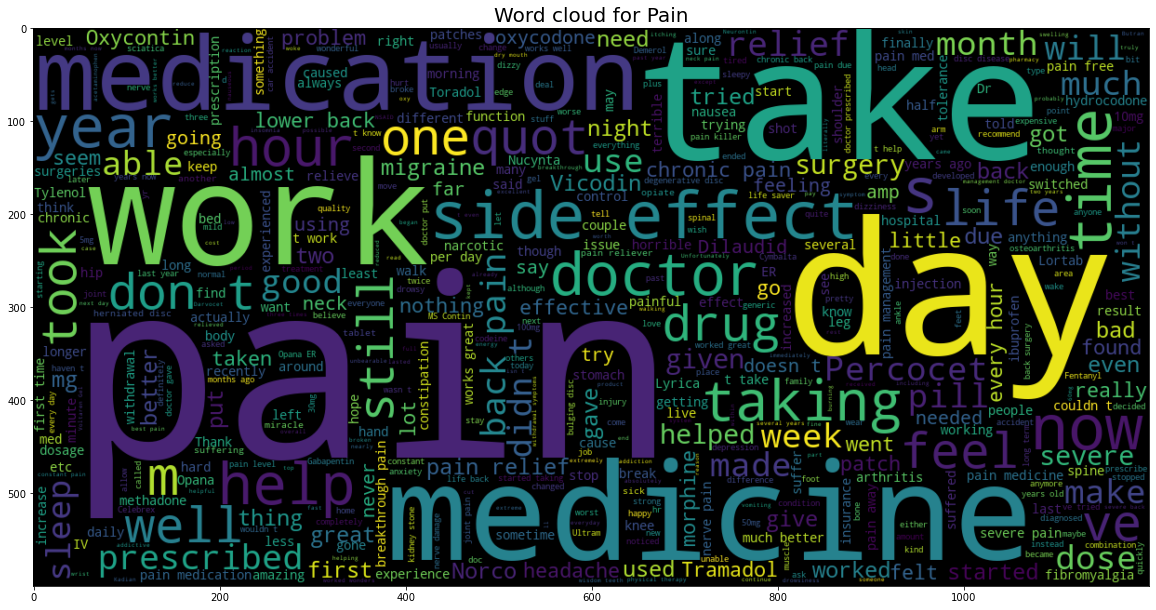

In [29]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1200 , height = 600).generate(" ".join(X_pain.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Pain',fontsize=20)

Text(0.5, 1.0, 'Word cloud for Depression')

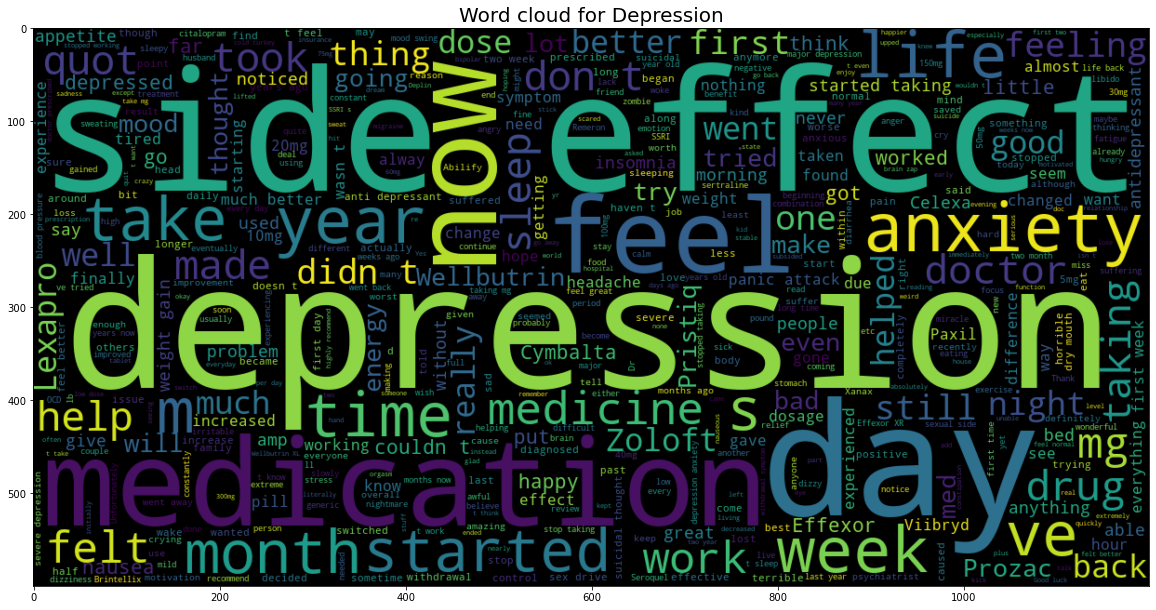

In [30]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1200 , height = 600).generate(" ".join(X_dep.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for Depression',fontsize=20)

Text(0.5, 1.0, 'Word cloud for anxiety')

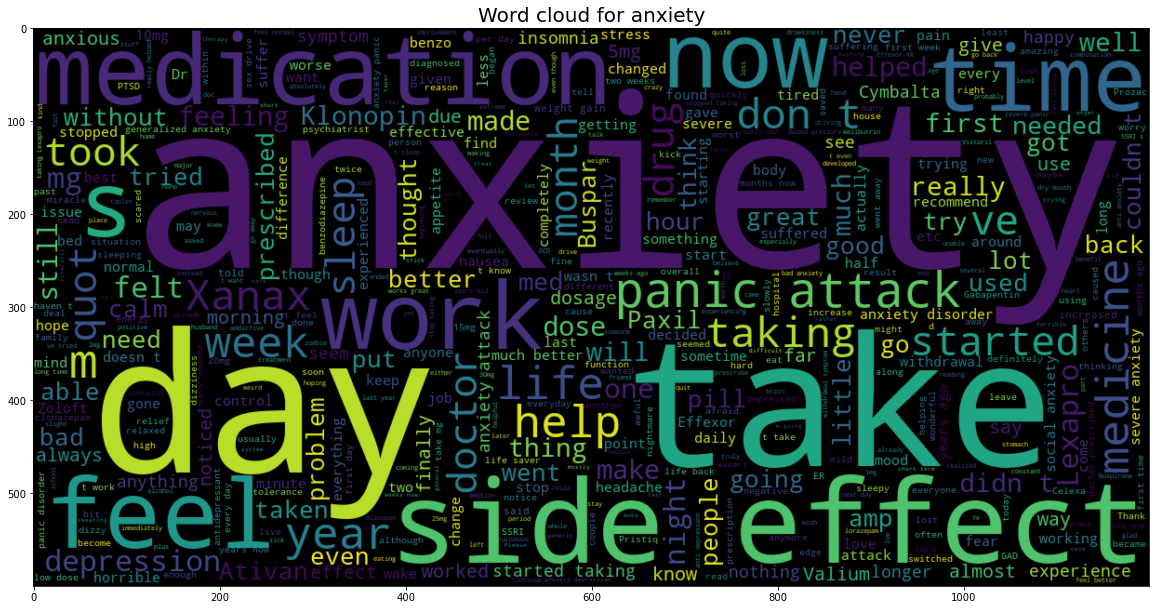

In [31]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1200 , height = 600).generate(" ".join(X_anx.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for anxiety',fontsize=20)

Text(0.5, 1.0, 'Word cloud for weight Loss')

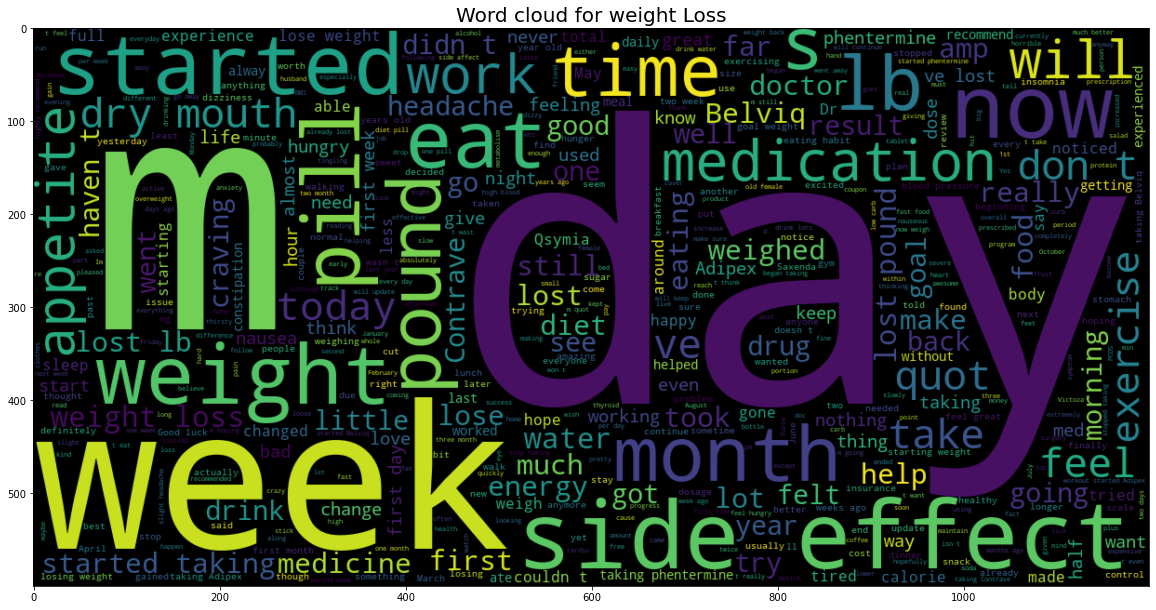

In [32]:
from wordcloud import WordCloud
plt.figure(figsize = (20,20)) # Text that is Fake News Headlines
wc = WordCloud(max_words = 500 , width = 1200 , height = 600).generate(" ".join(X_wt.review))
plt.imshow(wc , interpolation = 'bilinear')
plt.title('Word cloud for weight Loss',fontsize=20)

### Creating features and Target Variable

In [33]:
X_feat=X['review_clean']
y=X['condition']

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_feat, y,stratify=y,test_size=0.2, random_state=0)

### Bag of Words

In [35]:
count_vectorizer = CountVectorizer(stop_words='english')

count_train = count_vectorizer.fit_transform(X_train)

count_test = count_vectorizer.transform(X_test)

In [36]:
count_train

<19781x14677 sparse matrix of type '<class 'numpy.int64'>'
	with 580853 stored elements in Compressed Sparse Row format>

In [37]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    See full source and example: 
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(12,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Machine Learning Model : Naive Bayes

In [38]:
mnb = MultinomialNB()
mnb.fit(count_train, y_train)
pred = mnb.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

accuracy:   0.865


Confusion matrix, without normalization


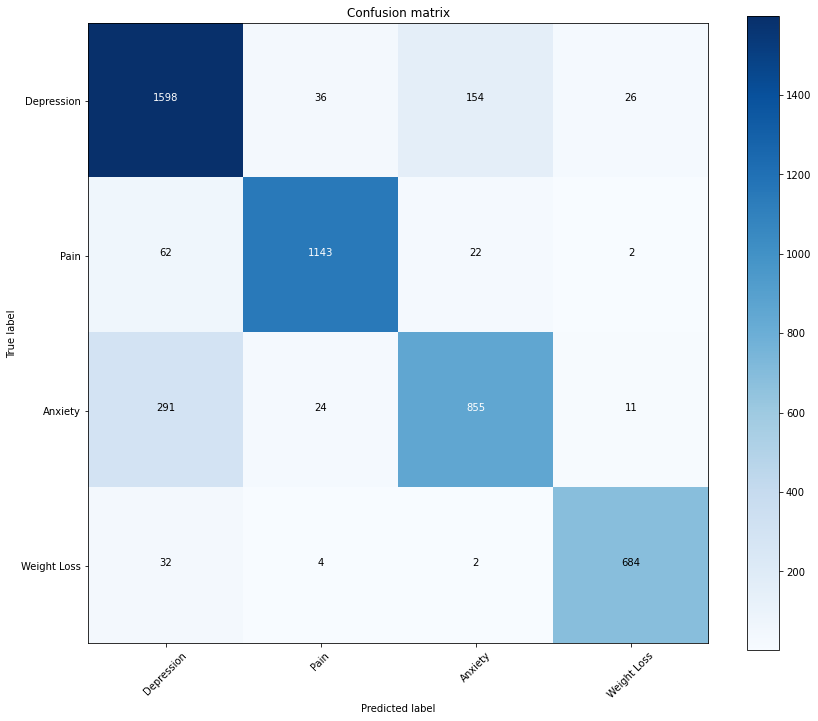

In [39]:
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression', 'Pain','Anxiety','Weight Loss'])
plot_confusion_matrix(cm, classes=['Depression', 'Pain','Anxiety','Weight Loss'])

### Machine Learning Model : Passive Aggressive Classifier

accuracy:   0.885
Confusion matrix, without normalization


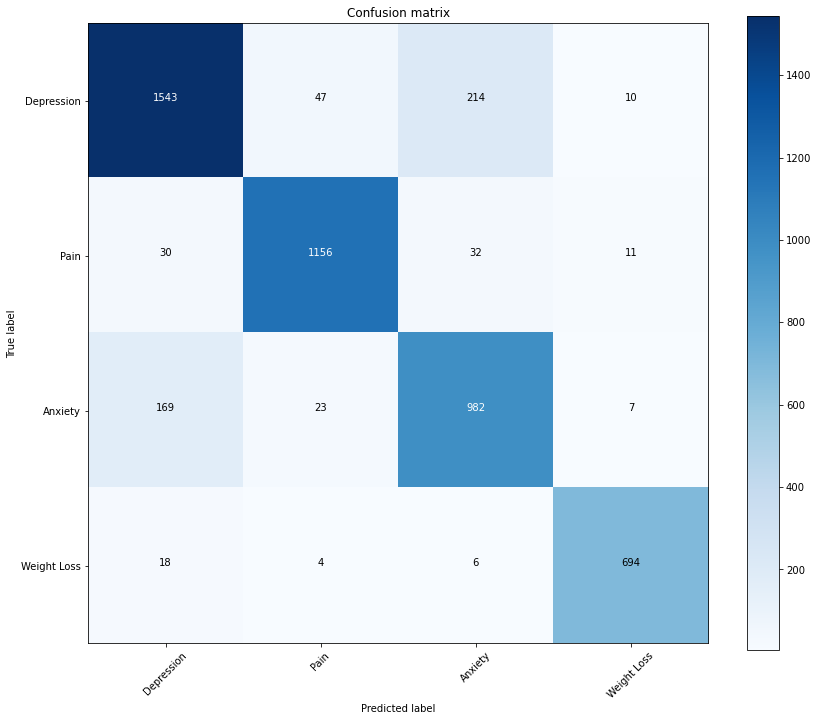

In [40]:
passive = PassiveAggressiveClassifier()
passive.fit(count_train, y_train)
pred = passive.predict(count_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression', 'Pain','Anxiety','Weight Loss'])
plot_confusion_matrix(cm, classes=['Depression', 'Pain','Anxiety','Weight Loss'])

### Tfidf Vectorizer

accuracy:   0.895
Confusion matrix, without normalization


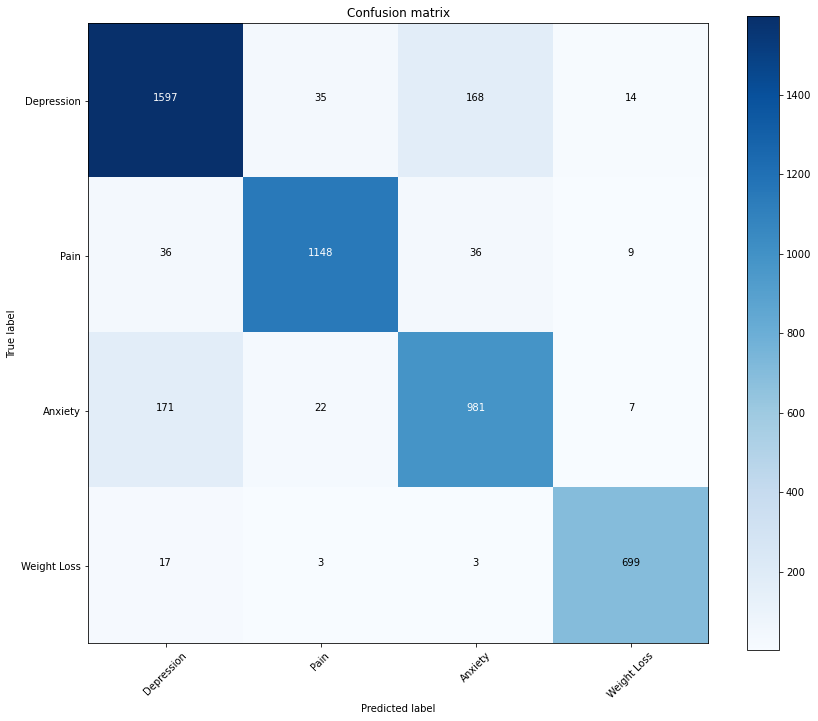

In [41]:
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
model=pass_tf.fit(tfidf_train, y_train)
pred = pass_tf.predict(tfidf_test)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression', 'Pain','Anxiety','Weight Loss'])
plot_confusion_matrix(cm, classes=['Depression', 'Pain','Anxiety','Weight Loss'])

### TfIDF:- Bigrams

In [42]:
tfidf_vectorizer2 = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1,2))
tfidf_train_2 = tfidf_vectorizer2.fit_transform(X_train)
tfidf_test_2 = tfidf_vectorizer2.transform(X_test)

accuracy:   0.919
Confusion matrix, without normalization


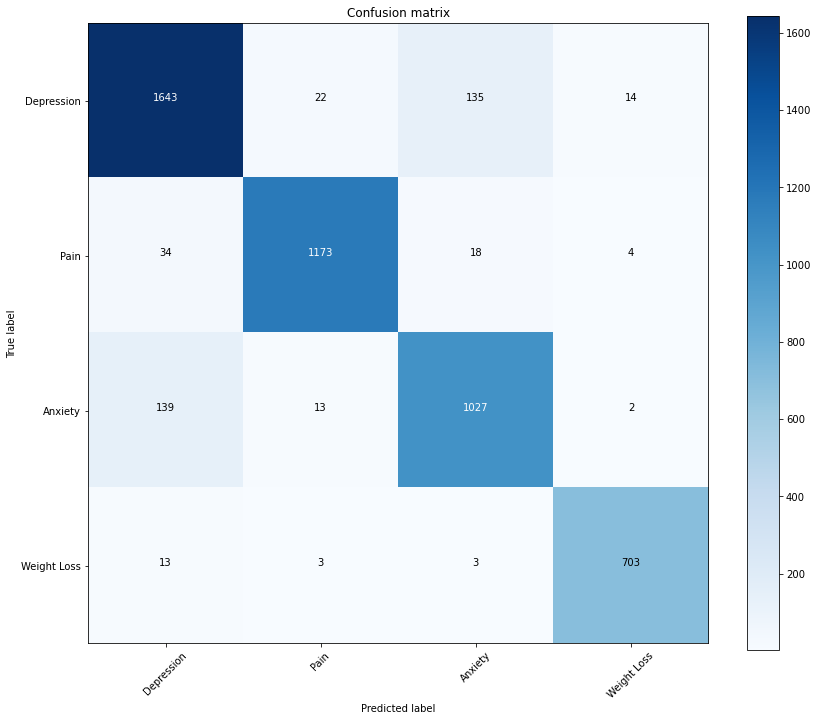

In [43]:
pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_2, y_train)
pred = pass_tf.predict(tfidf_test_2)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)
cm = metrics.confusion_matrix(y_test, pred, labels=['Depression', 'Pain','Anxiety','Weight Loss'])
plot_confusion_matrix(cm, classes=['Depression', 'Pain','Anxiety','Weight Loss'])

### TfIDF:- Trigrams

accuracy:   0.923
Confusion matrix, without normalization


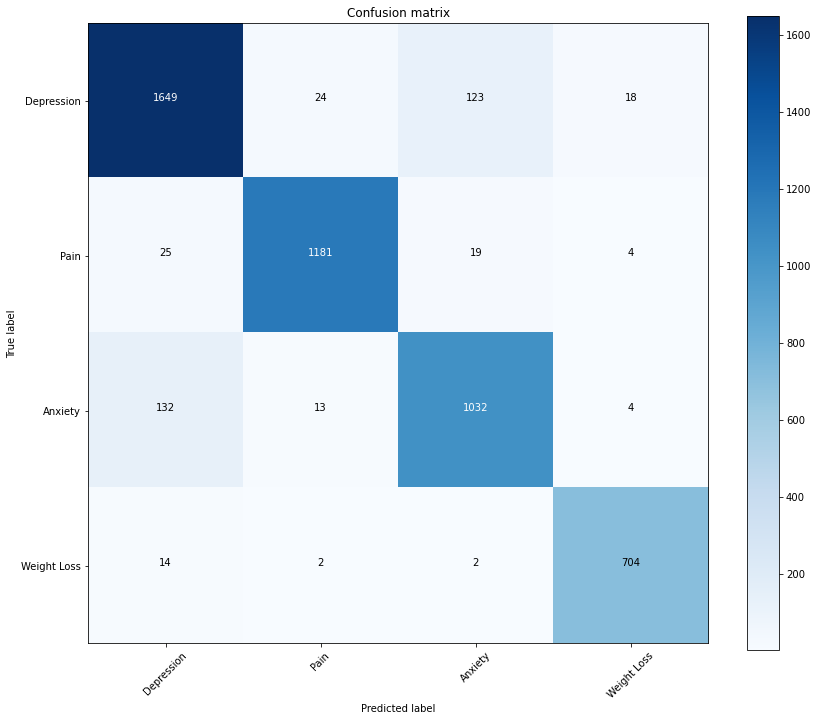

In [44]:
tfidf_vectorizer3 = TfidfVectorizer(stop_words='english', max_df=0.7, ngram_range=(1,3))
tfidf_train_3 = tfidf_vectorizer3.fit_transform(X_train)
tfidf_test_3 = tfidf_vectorizer3.transform(X_test)

pass_tf = PassiveAggressiveClassifier()
pass_tf.fit(tfidf_train_3, y_train)
pred = pass_tf.predict(tfidf_test_3)
score = metrics.accuracy_score(y_test, pred)
print("accuracy:   %0.3f" % score)

cm = metrics.confusion_matrix(y_test, pred, labels=['Depression', 'Pain','Anxiety','Weight Loss'])
plot_confusion_matrix(cm, classes=['Depression', 'Pain','Anxiety','Weight Loss'])

### Most Important Feature

In [45]:
def most_informative_feature_for_class(vectorizer, classifier, classlabel, n=7):
    labelid = list(classifier.classes_).index(classlabel)
    feature_names = vectorizer.get_feature_names()
    topn = sorted(zip(classifier.coef_[labelid], feature_names))[-n:]

    for coef, feat in topn:
        print (classlabel, feat, coef)


In [46]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Depression')

Depression pprobably 0.7051017564988395
Depression degenerating 0.7142915867243513
Depression degeneration 0.7142915867243513
Depression pullled 0.746540312829134
Depression fir 0.7803189568839932
Depression clo 0.8290965862199465
Depression acting 4.197288277691104


C:\Users\chaud\AppData\Roaming\Python\Python39\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [47]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Pain')

Pain chonic 0.8460310654984449
Pain cc 0.8669104299049418
Pain doxepin 0.8902919031930986
Pain glancing 1.0347662706489131
Pain mamgement 1.0731438827381181
Pain immediately 1.3369655959888964
Pain depleted 1.7979179034962238


In [48]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Anxiety')

Anxiety rrom 0.7376553373306356
Anxiety percent 0.763687938022236
Anxiety pretended 0.7641700611245038
Anxiety tackle 0.7884012774251644
Anxiety realisation 0.8563946063470127
Anxiety tappered 1.1002896136622382
Anxiety menopausal 1.1481816421770876


In [49]:
most_informative_feature_for_class(tfidf_vectorizer, pass_tf, 'Weight Loss')

Weight Loss painfull 0.49299912623998926
Weight Loss path 0.5600637473507531
Weight Loss gynecologist 0.5938656011761473
Weight Loss pharmacy 0.6378684461905497
Weight Loss gyno 0.7269934486484119
Weight Loss sloshing 0.8669980774303644
Weight Loss organized 4.301965711118301


### Sample Prediction

In [50]:
X.tail()

,condition,review,review_clean
161256,Pain,"I have had both knees arthroscopic in the last year and half. I ended up reinjurying one knee and when this happened the other knee begins to swell and hurt because it is compensating for the injury knee. I found out I have Pesanserine bursitis, which is very painful especially going up stairs. I was beginning to shuffle from one room to another. I had two Zipsor left from a sample pack I got from the doctor. I try to hang on to them in case my pain got worse. Since my doctors office had not received any samples I ask if they could call in a prescription. I didn&#039;t care about the cost. Zipsor has helped the pain and swelling tremendously in my knees. Since I have arthritis in my knees I know this will be my go to as needed pain reliever.",knee arthroscopic last year half ended reinjurying one knee happened knee begin swell hurt compensating injury knee found pesanserine bursitis painful especially going stair beginning shuffle one room another two zipsor left sample pack got doctor try hang case pain got worse since doctor office received sample ask could call prescription care cost zipsor helped pain swelling tremendously knee since arthritis knee know go needed pain reliever
161270,Anxiety,"I have been taking Cymbalta for 15 months now. First 30mg and then six months later up it to 60mgs/day. It was prescribed to me for clinical depression. It works for the depression and I also noticed it has worked very well for anxiety also. My MD and I have discussed that I probably have had this anxiety disorder for some time and curtailed with the depression, Cymbalta has done well for both. Side effects are weight gain (5-10 lbs), and bad withdrawal effects if you miss a day or two - headaches. Otherwise, the medication has worked very well and I feel like I can live my life again.",taking cymbalta month first mg six month later mg day prescribed clinical depression work depression also noticed worked well anxiety also md discussed probably anxiety disorder time curtailed depression cymbalta done well side effect weight gain lb bad withdrawal effect miss day two headache otherwise medication worked well feel like live life
161276,Anxiety,"About 4 years ago I started having early-morning awakening/insomnia/anxiety after excessive alcohol consumption the night before. Discovered that I could prevent this by taking diazepam my wife had lying around. When this ran out my GP prescribed lorazepam 0.5 mg. Gradually this lost effectiveness (tolerance) so I quit, also cut down on alcohol. A year ago I had a stressful situation and started 0.5 mg daily for a month, but was able to stop again with no side effects. However, my early-morning awakening/insomnia/anxiety had become chronic and independent of alcohol. A month ago I started 0.5 mg daily for 10 days, had a severe withdrawal, had to taper off. So, yes, like others wrote here: it works great, but not for chronic use.",year ago started early morning awakening insomnia anxiety excessive alcohol consumption night discovered could prevent taking diazepam wife lying around ran gp prescribed lorazepam mg gradually lost effectiveness tolerance quit also cut alcohol year ago stressful situation started mg daily month able stop side effect however early morning awakening insomnia anxiety become chronic independent alcohol month ago started mg daily day severe withdrawal taper yes like others wrote work great chronic use
161286,Depression,"This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",third med tried anxiety mild depression week hate much dizzy major diarrhea feel worse started contacting doc changing asap
161287,Anxiety,"I was super against taking medication. I&#039;ve started dealing with anxiety (some depression) for awhile now. I got prescribed Ativan months ago, a

In [53]:
## function for extracting the top drugs

def top_drugs_extractor(condition):
    df_top = df[(df['rating']>=9)&(df['usefulCount']>=100)].sort_values(by = ['rating', 'usefulCount'], ascending = [False, False])
    drug_lst = df_top[df_top['condition']==condition]['drugName'].head(3).tolist()
    return drug_lst

In [54]:
def predict_text(lst_text):
    df_test = pd.DataFrame(lst_text, columns = ['test_sent'])
    df_test["test_sent"] = df_test["test_sent"].apply(review_to_words)
    tfidf_bigram = tfidf_vectorizer3.transform(lst_text)
    prediction = pass_tf.predict(tfidf_bigram)
    df_test['prediction']=prediction
    return df_test

In [55]:
sentences = [
  "About 4 years ago I started having early-morning awakening/insomnia/anxiety after excessive alcohol consumption the night before. Discovered that I could prevent this by taking diazepam my wife had lying around. When this ran out my GP prescribed lorazepam 0.5 mg. Gradually this lost effectiveness (tolerance) so I quit, also cut down on alcohol. A year ago I had a stressful situation and started 0.5 mg daily for a month, but was able to stop again with no side effects. However, my early-morning awakening/insomnia/anxiety had become chronic and independent of alcohol. A month ago I started 0.5 mg daily for 10 days, had a severe withdrawal, had to taper off. So, yes, like others wrote here: it works great, but not for chronic use",
   "This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I started. Contacting my doc in the am and changing asap.",
    "I have had both knees arthroscopic in the last year and half. I ended up reinjurying one knee and when this happened the other knee begins to swell and hurt because it is compensating for the injury knee. I found out I have Pesanserine bursitis, which is very painful especially going up stairs. I was beginning to shuffle from one room to another. I had two Zipsor left from a sample pack I got from the doctor. I try to hang on to them in case my pain got worse. Since my doctors office had not received any samples I ask if they could call in a prescription. I didn&#039;t care about the cost. Zipsor has helped the pain and swelling tremendously in my knees. Since I have arthritis in my knees I know this will be my go to as needed pain reliever."
  ]

In [56]:
tfidf_trigram = tfidf_vectorizer3.transform(sentences)


predictions = pass_tf.predict(tfidf_trigram)

for text, label in zip(sentences, predictions):
    if label=="Pain":
        target="Pain"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Depression":
        target="Depression"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    elif label=="Anxiety":
        target="Anxiety"
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()
    else:
        target="Weight Loss"
        print("text:", text, "\Condition:", target)
        top_drugs = top_drugs_extractor(label)
        print("text:", text, "\nCondition:", target)
        print("Top 3 Suggested Drugs:")
        print(top_drugs[0])
        print(top_drugs[1])
        print(top_drugs[2])
        print()

text: About 4 years ago I started having early-morning awakening/insomnia/anxiety after excessive alcohol consumption the night before. Discovered that I could prevent this by taking diazepam my wife had lying around. When this ran out my GP prescribed lorazepam 0.5 mg. Gradually this lost effectiveness (tolerance) so I quit, also cut down on alcohol. A year ago I had a stressful situation and started 0.5 mg daily for a month, but was able to stop again with no side effects. However, my early-morning awakening/insomnia/anxiety had become chronic and independent of alcohol. A month ago I started 0.5 mg daily for 10 days, had a severe withdrawal, had to taper off. So, yes, like others wrote here: it works great, but not for chronic use 
Condition: Anxiety
Top 3 Suggested Drugs:
Alprazolam
Xanax
Buspirone

text: This is the third med I&#039;ve tried for anxiety and mild depression. Been on it for a week and I hate it so much. I am so dizzy, I have major diarrhea and feel worse than I star